In [1]:
import csv
import gzip
import logomaker
import numpy as np
import pandas as pd
import torch
from captum.attr import DeepLift, Saliency
from captum.attr import visualization as viz
from torch.utils.data import DataLoader

# add smoothGrad/noiseTunnel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/aakash/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
from refactor import ConvNet, chipseq_dataset


def seqtopad(sequence, motiflen, kind="DNA"):
    rows = len(sequence) + 2 * motiflen - 2
    S = np.zeros([rows, 4], dtype=np.float32)
    base = "ACGT" if kind == "DNA" else "ACGU"
    for i in range(rows):
        if i < motiflen - 1 or i >= len(sequence) + motiflen - 1:
            S[i] = 0.25
        elif sequence[i - motiflen + 1] in base:
            S[i, base.index(sequence[i - motiflen + 1])] = 1
    return S.T


class Chip_test:
    def __init__(self, filename, motiflen=24):
        self.file = filename
        self.motiflen = motiflen

    def openFile(self):
        test_dataset = []
        with gzip.open(self.file, "rt") as data:
            next(data)
            reader = csv.reader(data, delimiter="\t")
            for row in reader:
                test_dataset.append([seqtopad(row[2], self.motiflen), [int(row[3])]])
        return test_dataset


chipseq_test = Chip_test(
    "/mnt/f/Projects/GenomicAttributions/data/encode/GATA1_K562_GATA-1_USC_B.seq.gz"
)
test_data = chipseq_test.openFile()
test_dataset = chipseq_dataset(test_data)
batchSize = test_dataset.__len__()
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)

cuda:0


## Load Trained Model

In [3]:
best_hyperparameters = torch.load(
    "/mnt/f/Projects/GenomicAttributions/models/deepBIND/best_hyperpamarameters.pth"
)
best_poolType = best_hyperparameters["best_poolType"]
best_neuType = best_hyperparameters["best_neuType"]
best_learning_steps = best_hyperparameters["best_learning_steps"]
best_LearningRate = best_hyperparameters["best_LearningRate"]
best_dropprob = best_hyperparameters["best_dropprob"]
best_LearningMomentum = best_hyperparameters["best_LearningMomentum"]
best_sigmaConv = best_hyperparameters["best_sigmaConv"]
best_sigmaNeu = best_hyperparameters["best_sigmaNeu"]
best_beta1 = best_hyperparameters["best_beta1"]
best_beta2 = best_hyperparameters["best_beta2"]
best_beta3 = best_hyperparameters["best_beta3"]
config = {
    "nummotif": 16,
    "motiflen": 24,
    "poolType": best_poolType,
    "neuType": best_neuType,
    "dropprob": best_dropprob,
    "sigmaConv": best_sigmaConv,
    "sigmaNeu": best_sigmaNeu,
    "learning_rate": best_LearningRate,
    "momentum_rate": best_LearningMomentum,
    "beta1": best_beta1,
    "beta2": best_beta2,
    "beta3": best_beta3,
}
DeepBIND_model = ConvNet(config).to(device)
checkpoint = torch.load(
    "/mnt/f/Projects/GenomicAttributions/models/deepBIND/MyModel_2.pth"
)
DeepBIND_model.wConv = checkpoint["conv"]
DeepBIND_model.wRect = checkpoint["rect"]
DeepBIND_model.wHidden = checkpoint["wHidden"]
DeepBIND_model.wHiddenBias = checkpoint["wHiddenBias"]
DeepBIND_model.wNeu = checkpoint["wNeu"]
DeepBIND_model.wNeuBias = checkpoint["wNeuBias"]

net = DeepBIND_model

## Generate Attribution Maps

In [4]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input, **kwargs)
    return tensor_attributions


original_image = np.transpose((data.cpu().detach().numpy()), (0, 1, 2))

saliency = Saliency(net)
grads = saliency.attribute(data)
grads = grads.squeeze().cpu().detach().numpy()

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, data, baselines=data * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (0, 1, 2))

print(grads.shape, attr_dl.shape, original_image.shape)
index = np.random.randint(0, grads.shape[0])
print(index)
grads = grads[index]
original_image = original_image[index]
attr_dl = attr_dl[index]

print(grads.shape, attr_dl.shape, original_image.shape)
grads = grads.reshape(4, 147, 1)
attr_dl = attr_dl.reshape(4, 147, 1)
original_image = original_image.reshape(4, 147, 1)
print(grads.shape, attr_dl.shape, original_image.shape)

/home/aakash/miniconda3/envs/TFBS/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


(1000, 4, 147) (1000, 4, 147) (1000, 4, 147)
61
(4, 147) (4, 147) (4, 147)
(4, 147, 1) (4, 147, 1) (4, 147, 1)


/home/aakash/miniconda3/envs/TFBS/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


## Plot

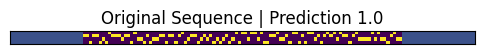

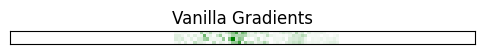

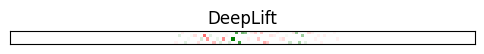

In [5]:
_ = viz.visualize_image_attr(
    None,
    original_image,
    method="original_image",
    title="Original Sequence | Prediction {}".format(target[index][0]),
)
_ = viz.visualize_image_attr(
    grads, original_image, method="heat_map", sign="all", title="Vanilla Gradients"
)
_ = viz.visualize_image_attr(
    attr_dl, original_image, method="heat_map", sign="all", title="DeepLift"
)

## Motifs

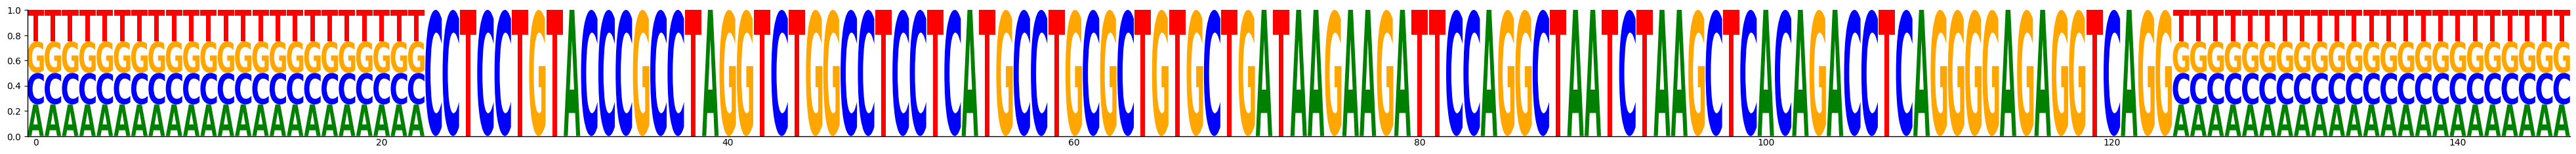

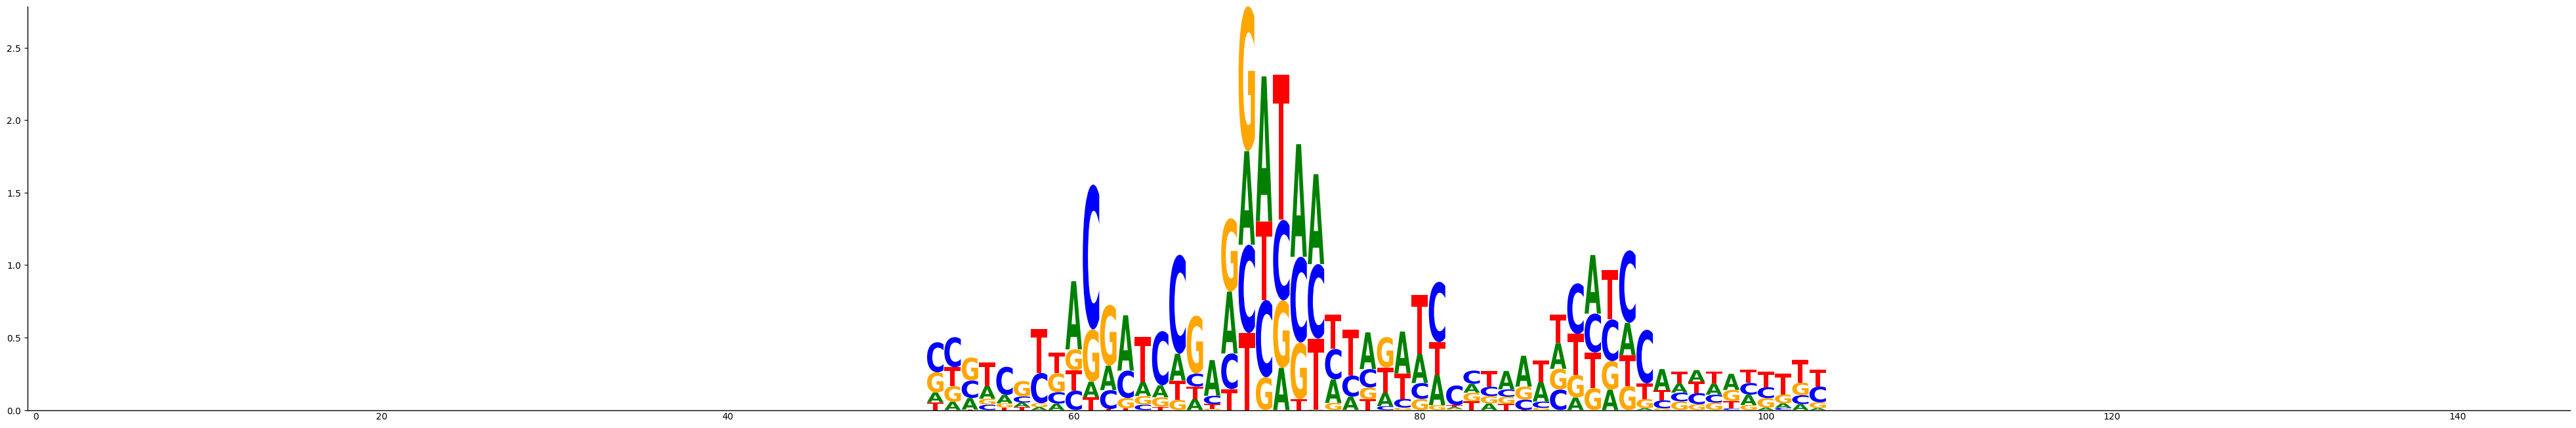

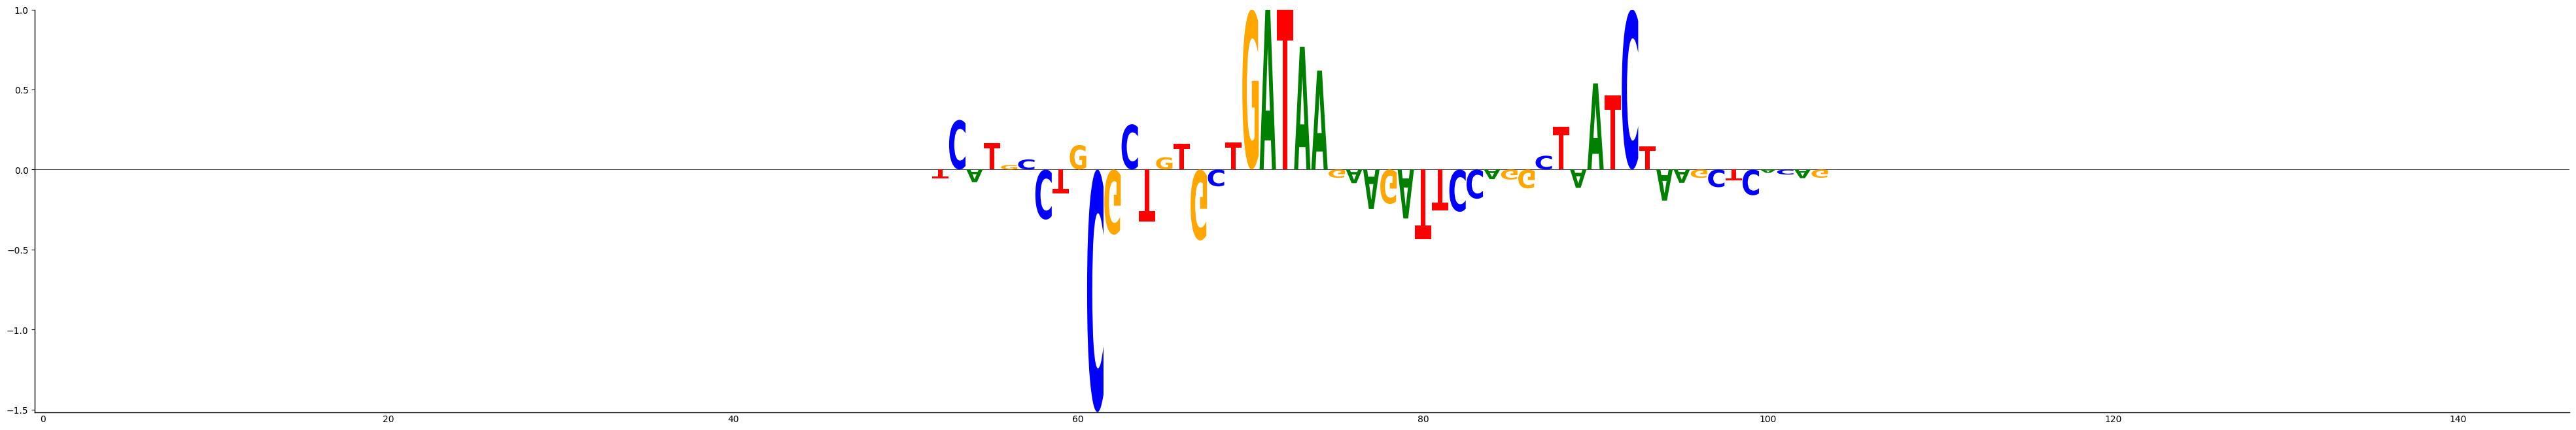

In [6]:
def create_logo(data, figsize, scale_data=False, visible_spines=None):
    if visible_spines is None:
        visible_spines = ["left", "bottom"]

    # Reshape and prepare the data
    output = {
        nucleotide: data[idx].reshape(147) for idx, nucleotide in enumerate("ACGT")
    }
    df = pd.DataFrame(output)

    # Optionally scale the data
    if scale_data:
        df /= df.max()

    # Create Logo object
    logo = logomaker.Logo(df, figsize=figsize)

    # Style the logo
    logo.style_spines(visible=False)
    logo.style_spines(spines=visible_spines, visible=True)
    logo.ax.set_ylabel("", labelpad=-1)
    logo.ax.xaxis.set_ticks_position("none")
    logo.ax.xaxis.set_tick_params(pad=-1)
    return logo


# Create logos for each dataset
crp_df_original_logo = create_logo(original_image, figsize=[50, 2.5])
crp_logo = create_logo(grads, figsize=[50, 8], scale_data=True)
dl_crp_df_logo = create_logo(attr_dl, figsize=[50, 8], scale_data=True)

---

/tmp/ipykernel_755133/2308828782.py:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.x_data = torch.tensor([el[0] for el in xy], dtype=torch.float32)


(1000, 4, 147) (1000, 4, 147)
713
(4, 147) (4, 147)
(4, 147, 1) (4, 147, 1)


/home/aakash/miniconda3/envs/TFBS/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


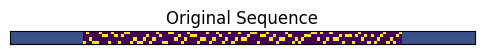

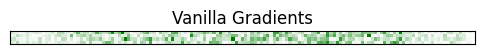

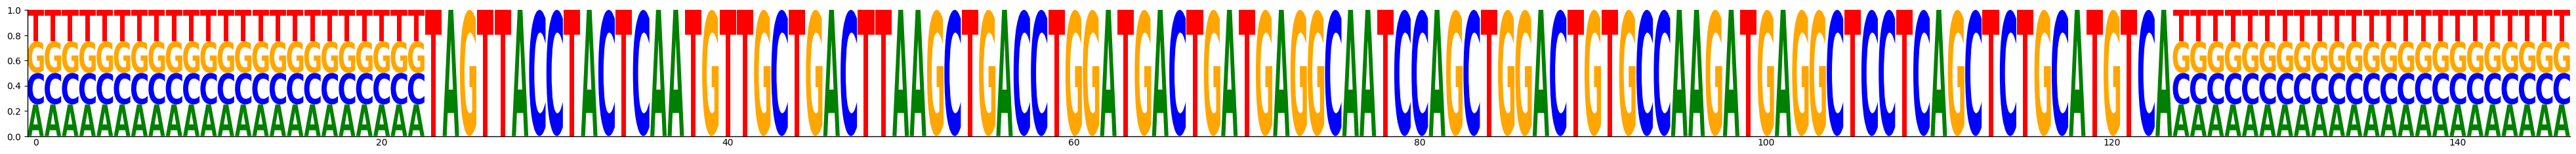

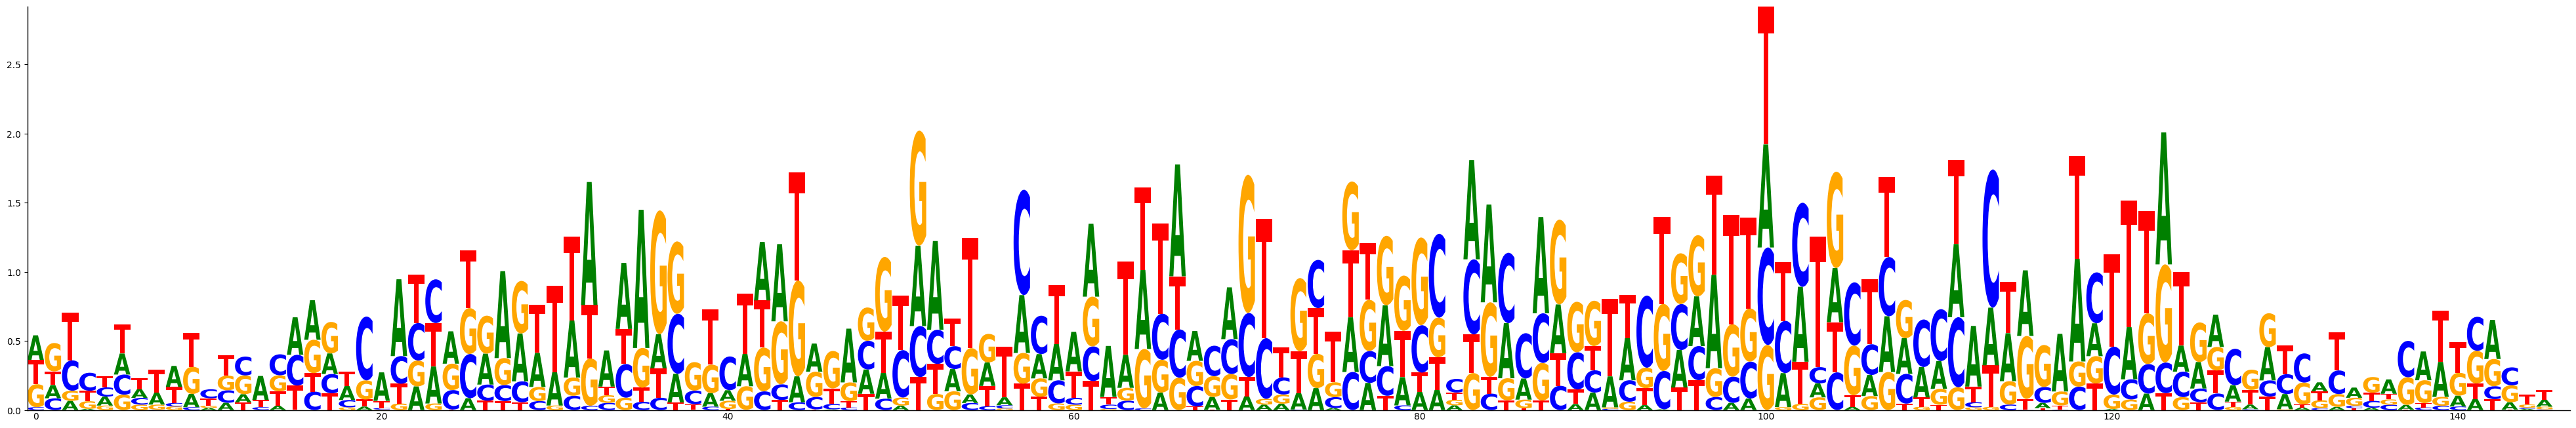

In [7]:
import csv
import gzip

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
from captum.attr import Saliency
from captum.attr import visualization as viz
from torch.utils.data import DataLoader, Dataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CNNEmbedding(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(CNNEmbedding, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64 * 36, embedding_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(
        self,
        embedding_dim,
        dropout_rate=0.5,
        dim_feedforward=512,
        nhead=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = CNNEmbedding(embedding_dim, dropout_rate)
        self.transformer = nn.Transformer(
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            d_model=embedding_dim,
            dim_feedforward=dim_feedforward,
            batch_first=True,
        )
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer(src, src)
        output = self.fc(output)
        return output


class ChipDataLoader:
    def __init__(self, filename, motiflen=24):
        self.filename = filename
        self.motiflen = motiflen

    def seqtopad(self, sequence, kind="DNA"):
        rows = len(sequence) + 2 * self.motiflen - 2
        S = np.zeros([rows, 4], dtype=np.float32)
        base = "ACGT" if kind == "DNA" else "ACGU"
        for i in range(rows):
            if i < self.motiflen - 1 or i >= len(sequence) + self.motiflen - 1:
                S[i] = 0.25
            elif sequence[i - self.motiflen + 1] in base:
                S[i, base.index(sequence[i - self.motiflen + 1])] = 1
        return S.T

    def load_data(self):
        data_set = []
        with gzip.open(self.filename, "rt") as file:
            next(file)  # Skip header if necessary
            reader = csv.reader(file, delimiter="\t")
            for row in reader:
                sequence = row[2]
                label = int(row[3])
                padded_sequence = self.seqtopad(sequence)
                data_set.append([padded_sequence, label])
        return data_set


class chipseq_dataset(Dataset):
    def __init__(self, xy):
        self.x_data = torch.tensor([el[0] for el in xy], dtype=torch.float32)
        self.y_data = torch.tensor([el[1] for el in xy], dtype=torch.float32)
        self.len = len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


chipseq_test = ChipDataLoader(
    "/mnt/f/Projects/GenomicAttributions/data/encode/GATA1_K562_GATA-1_USC_B.seq.gz"
)
testdataset = chipseq_test.load_data()
test_dataset = chipseq_dataset(testdataset)
test_batch_size = test_dataset.len
test_loader = DataLoader(
    dataset=test_dataset, batch_size=test_batch_size, shuffle=False
)
study = optuna.load_study(
    study_name="transformer",
    storage="sqlite:///transformer.db",
)
model = TransformerModel(
    embedding_dim=study.best_trial.params["embedding_dim"],
    dropout_rate=study.best_trial.params["dropout_rate"],
    num_encoder_layers=study.best_trial.params["num_encoder_layers"],
    num_decoder_layers=study.best_trial.params["num_decoder_layers"],
).to(device)
model.load_state_dict(torch.load("transformer.pth"))

net = model.to(device)

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)

original_image = np.transpose((data.cpu().detach().numpy()), (0, 1, 2))

saliency = Saliency(net)
grads = saliency.attribute(data)
grads = grads.squeeze().cpu().detach().numpy()

print(grads.shape, original_image.shape)
# index = 4
index = np.random.randint(0, grads.shape[0])
print(index)
grads = grads[index]
original_image = original_image[index]
print(grads.shape, original_image.shape)
grads = grads.reshape(4, 147, 1)
original_image = original_image.reshape(4, 147, 1)
print(grads.shape, original_image.shape)

_ = viz.visualize_image_attr(
    None, original_image, method="original_image", title="Original Sequence"
)
_ = viz.visualize_image_attr(
    grads, original_image, method="heat_map", sign="all", title="Vanilla Gradients"
)


def create_logo(data, figsize, scale_data=False, visible_spines=None):
    if visible_spines is None:
        visible_spines = ["left", "bottom"]

    # Reshape and prepare the data
    output = {
        nucleotide: data[idx].reshape(147) for idx, nucleotide in enumerate("ACGT")
    }
    df = pd.DataFrame(output)

    # Optionally scale the data
    if scale_data:
        df /= df.max()

    # Create Logo object
    logo = logomaker.Logo(df, figsize=figsize)

    # Style the logo
    logo.style_spines(visible=False)
    logo.style_spines(spines=visible_spines, visible=True)
    logo.ax.set_ylabel("", labelpad=-1)
    logo.ax.xaxis.set_ticks_position("none")
    logo.ax.xaxis.set_tick_params(pad=-1)
    return logo


# Create logos for each dataset
crp_df_original_logo = create_logo(original_image, figsize=[50, 2.5])
crp_logo = create_logo(grads, figsize=[50, 8], scale_data=True)